# Title

### Date
### Author

## Summary

Blah Blah

---

### Import packages and data

In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install pandas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
plt.style.use('bmh')

In [8]:
# variables useful throughout the analysis
local_fp = './data.csv'
remote_fp = 'https://standard-traffic-data.s3.us-east-2.amazonaws.com/most_0400_0600_1_5.csv'

In [10]:
# get the dataset from remote, only if the local file does not exist
# this will require your OS to have wget
# otherwise check out this package: https://pypi.org/project/wget/
!wget -nc $remote_fp -O $local_fp

File `./data.csv' already there; not retrieving.


In [61]:
data = pd.read_csv(local_fp, sep=';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067350 entries, 0 to 2067349
Data columns (total 20 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestep_time  float64
 1   vehicle_angle  float64
 2   vehicle_id     object 
 3   vehicle_lane   object 
 4   vehicle_pos    float64
 5   vehicle_slope  float64
 6   vehicle_speed  float64
 7   vehicle_type   object 
 8   vehicle_x      float64
 9   vehicle_y      float64
 10  vehicle_z      float64
 11  person_angle   float64
 12  person_edge    object 
 13  person_id      object 
 14  person_pos     float64
 15  person_slope   float64
 16  person_speed   float64
 17  person_x       float64
 18  person_y       float64
 19  person_z       float64
dtypes: float64(15), object(5)
memory usage: 315.5+ MB


It's generally useful to wipe rows of the dataset that contain just null values (whichever representation of null is there).

In this case though, no row will ever be entirely null, because the `timestep_time` feature is always given.

I could potentially filter out all rows that have all features null, excluding `timestep_time`. However, I think it's worth keeping them: they can show to us at what timestep we start seeing traffic.

In [62]:
# sanity check above the timestep feature
# see also comment above
data2 = data.dropna(how='all')
assert data2.shape == data.shape

### Feature cleaning

##### Check if person/vehicle columns are complementary

This idea deserves a verbal explanation, and it's not entirely clear to me.

Here's my (tentative) understanding:
- You consider features in pairs of columns, by looking for similar feature names.

Let's consider the first predicata only: `bothNAN`:
  - For each pair of columns, you keep elements of the first column only in the positions where the second column is null
  - At this point you have a Sequence (list-like). You call isna() on this sequence, which will yield a list of boolean values.
  - Each of these values will be True if the corresponding first column's element is null and the second column's element is also null.
  - Then you check if **any** of the values in such list of booleans is True.
  - Eventually, you will know if there was at least one position in those two columns where both were null. **At least one**.
  
Later on, if the result value for a pair of column was False, meaning that there wasn't any row in the dataset where those two columns are both null, you fill the null of the first column with the values from the second (which won't be null).

I can't see the idea behind this. Why would the missing values in `vehicle_angle` be in `person_angle`?

Site notes:

1. Calling isna -> values -> any should be redundant. I think you can just use any() on the data frame.
Example:

```
d1 = pd.DataFrame.from_dict({'a': [1, 2, np.nan, 3, 4], 'b': [9, np.nan, 13, 6, 11]})
print(d1.head())
both_nan = d1['a'][d1['b'].isna()].isna().any()
print('column "a": ', both_nan)
```
3. Assuming my understading is correct, here's a much simpler way to do it. And much more readable
```
np.where((d1['a'].isna()) & (d1['b'].isna()), True, False).any()
```
2. Save the features that you will want to drop/fill in a variable, depending on the true/false result. And then execute your next block of code based on this additional variable. Right now you execute it just looking at the visual output of the previous cell, but this requires editing it manually.
3. The property you're trying to prove here it's not valid in the dataset I downloaded from AWS (4am to 6am). See different output below.

Whatever is that you're trying to prove here, prove it statistically!


In [63]:
features = ['angle', 'id', 'pos', 'slope', 'speed', 'x', 'y', 'z']
for suffix in features:
    bothNAN = data['person_'+suffix][data['vehicle_'+suffix].isna()].isna().values.any()
    bothValues = data['person_'+suffix][data['vehicle_'+suffix].notna()].notna().values.any()
    print(suffix+":", bothNAN, bothValues)

angle: True False
id: True False
pos: True False
slope: True False
speed: True False
x: True False
y: True False
z: True False


##### Merge complementary columns and drop redundant ones

In [ ]:
for feature in features:
    data['vehicle_'+feature].fillna(data['person_'+feature], inplace=True)
    data.drop('person_'+feature, axis='columns', inplace=True)

data.info()

##### Check if same applies for "vehicle_lane" / "person_edge"

In [ ]:
bothNAN = data['person_edge'][data['vehicle_lane'].isna()].isna().values.any()
bothValues = data['person_edge'][data['vehicle_lane'].notna()].notna().values.any()

bothNAN, bothValues

##### Merge and drop

In [ ]:
data['vehicle_lane'].fillna(data['person_edge'], inplace=True)
data.drop('person_edge', axis='columns', inplace=True)

data.info()

##### Rename features

In [77]:
data.rename(columns={'timestep_time': "t", 'vehicle_angle': "angle", 'vehicle_id': "ID", 'vehicle_pos': "position",
                     'vehicle_slope': "slope", 'vehicle_speed': "speed", 'vehicle_x': "x", 'vehicle_y': "y",
                     'vehicle_z': "z", 'vehicle_lane': "lane_edge", 'vehicle_type': "v_type", }, inplace=True)

data.head()

,t,angle,ID,lane_edge,position,slope,speed,v_type,x,y,z,person_angle,person_edge,person_id,person_pos,person_slope,person_speed,person_x,person_y,person_z
0,14400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14405.0,80.89,bus_M1:France.0,152927_1,12.10,3.01,0.00,bus,1085.69,197.96,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14410.0,71.94,bus_M1:France.0,152927_1,23.63,1.31,3.97,bus,1096.59,201.56,54.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14415.0,57.57,bus_M1:France.0,152927_1,57.99,0.66,8.49,bus,1126.83,217.57,55.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14420.0,32.10,bus_M1:France.0,152927_1,113.32,0.63,12.78,bus,1167.22,253.89,55.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exploratory data analysis

##### Starting and end times

You are assuming the CSV is sorted :)
To be safe, better to use `pd.min` and `pd.max`

In [78]:
t = data['t'].iloc[0]
hI = int(t/3600)
mI = int(t/60 % 60)

t = data['t'].iloc[-1]
hF = int(t/3600)
mF = int(t/60 % 60)

print(F"Time interval: {hI}:{mI:02} - {hF}:{mF:02}")

Time interval: 4:00 - 5:59


##### Number of objects active at the same time

/home/pietro/.virtualenvs/stdTraffic/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


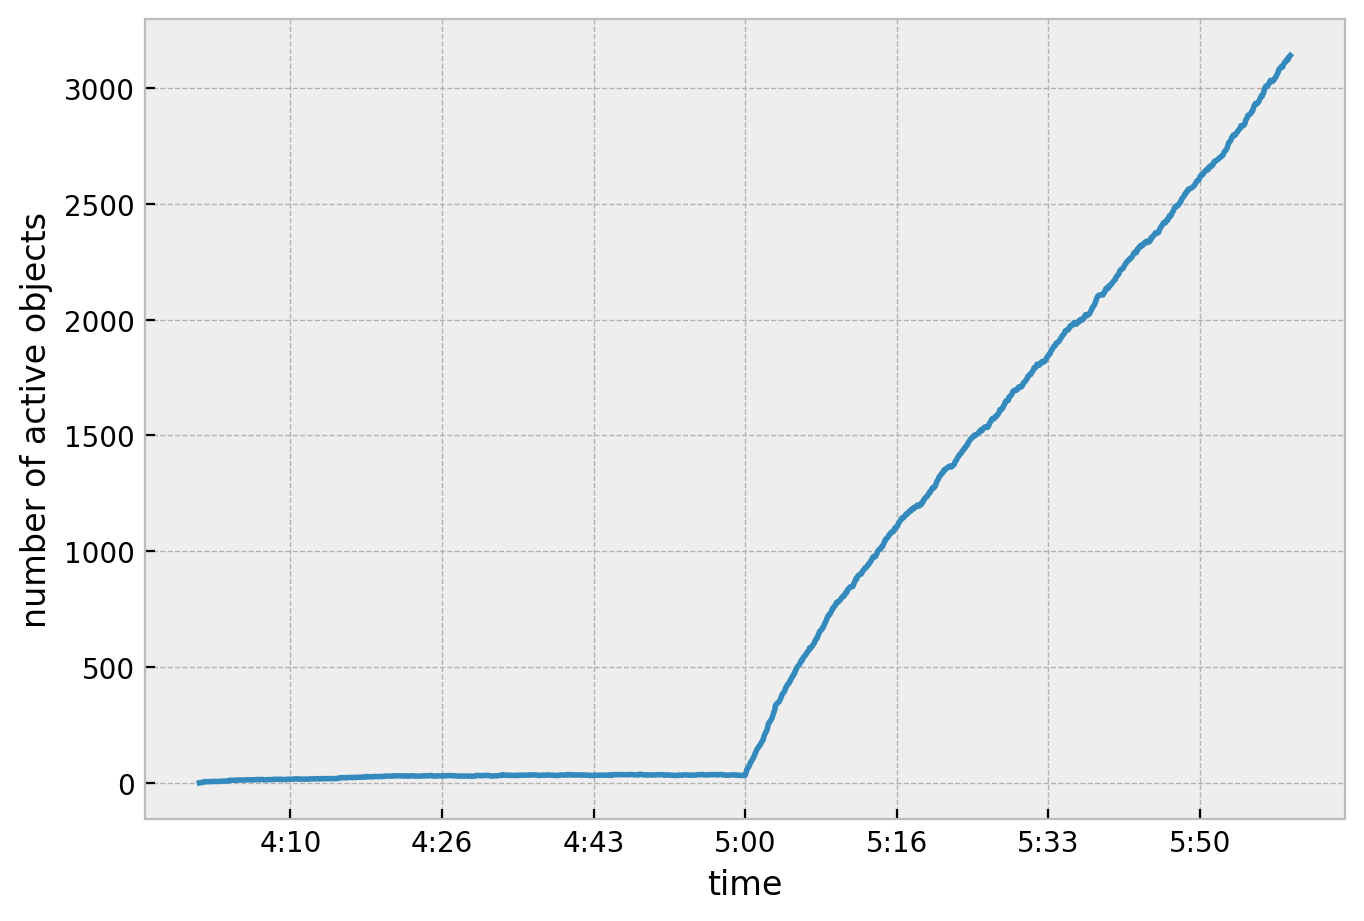

In [80]:
fig = plt.figure(dpi=200)
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(data.groupby(['t']).count()['ID'])

# ax.set_title('Active objects')
ax.set_xlabel('time')
ax.set_ylabel('number of active objects')

labels = []
for tick in ax.get_xticks():
    labels.append(F"{int(tick/3600)}:{int(tick/60 % 60):02}")
ax.set_xticklabels(labels);

A cumulative (over time) view of the number of object in the simulation is always useful!

Side Note: I think the code below is more standard for plotting data frames.

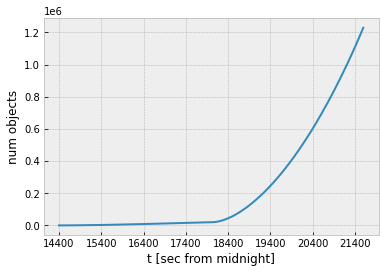

In [90]:
grouped = data.groupby(['t']).count()['ID']
cumulated = grouped.cumsum()
x_ticks = range(int(cumulated.index.min()), int(cumulated.index.max()), 1000)
_ = cumulated.plot(x=cumulated.index, y='ID',
                   kind='line', xticks=x_ticks,
                   xlabel='t [sec from midnight]', ylabel='num objects')

##### Min. and max. life time for object

In [91]:
a = data.groupby('ID').count()['t']  # definitely need to define this once for all :)
Delta = np.diff(data['t'].unique())[0]
print(F"Min. life time: {int((a.min()-1)*Delta/60)} m {int((a.min()-1)*Delta % 60)} s")
print(F"Max. life time: {int((a.max()-1)*Delta/60)} m {int((a.max()-1)*Delta % 60)} s")

Min. life time: 0 m 0 s
Max. life time: 59 m 50 s


##### It looks like some objects only appear in the simulation once:

We need to make an assumption, or give an explanation for this seemingly nonsense. Is it a "bug" in their simulation?

In [92]:
a[a==a.min()]

ID
pedestrian_1-1-pt_3865_tr    1
pedestrian_1-1-pt_4564_tr    1
pedestrian_1-1-pt_7931_tr    1
pedestrian_1-1-pt_821_tr     1
pedestrian_1-1-veh_522_tr    1
pedestrian_1-2_3_tr          1
pedestrian_1-3_1755_tr       1
pedestrian_1-GW1_2157_tr     1
pedestrian_1-GW2_963_tr      1
pedestrian_GW1-1_2022_tr     1
Name: t, dtype: int64

##### Number of vehicles, pedestrians and total objects in the simulation

In [93]:
p = len(data['ID'][data['v_type'].isna()].unique())
v = len(data['ID'][data['v_type'].notna()].unique())

print(F"{p+v} objects in the simulations, divided into {p} pedestrians and {v} vehicle of any type")
# sanity check
assert p+v == len(data['ID'].unique())

6149 objects in the simulations, divided into 1 pedestrians and 6148 vehicle of any type


##### Object demand by time

In [103]:
timeSteps = data['t'].unique()
newObjByTime = pd.Series(0, index=timeSteps)

# I believe this is a good excuse to learn pd.apply and then remove this loop. It's very slow!!
# I waited more than 2 minutes then I stopped it (that's why you see the error)
# I added dropna otherwise you get an error at runtime.
for obj in data['ID'].dropna().unique():
    timeFirstAppeared = data[data['ID']==obj]['t'].values[0]
    newObjByTime[timeFirstAppeared]+=1
    #print(str(i), end='\r') # ?? what was this? "i" is not defined

fig = plt.figure(dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
newObjByTime.plot.bar();

times = np.linspace(0, len(timeSteps), 10, endpoint=False, dtype=int)
ax.set_xticks(times);
labels = [F"{int(timeSteps[t]/3600)}:{int(timeSteps[t]/60 % 60):02}" for t in times]
ax.set_xticklabels(labels);

KeyboardInterrupt: 

In [96]:
data.head()

,t,angle,ID,lane_edge,position,slope,speed,v_type,x,y,z,person_angle,person_edge,person_id,person_pos,person_slope,person_speed,person_x,person_y,person_z
0,14400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14405.0,80.89,bus_M1:France.0,152927_1,12.10,3.01,0.00,bus,1085.69,197.96,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14410.0,71.94,bus_M1:France.0,152927_1,23.63,1.31,3.97,bus,1096.59,201.56,54.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14415.0,57.57,bus_M1:France.0,152927_1,57.99,0.66,8.49,bus,1126.83,217.57,55.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14420.0,32.10,bus_M1:France.0,152927_1,113.32,0.63,12.78,bus,1167.22,253.89,55.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
##### Let's isolate fast-wheeled vehicles to work on speed

In [104]:
data['v_type'].unique()
motoredObjects = ['hw_delivery', 'hw_trailer', 'bus', 'delivery', 'motorcycle', 'moped', 'taxi', 'uber', 'trailer',
                  'hw_truck', 'hw_coach', 'coach', 'truck', 'hw_motorcycle']
data2 = data[data['v_type'].isin(motoredObjects)]

In [106]:
data2.head()

,t,angle,ID,lane_edge,position,slope,speed,v_type,x,y,z,person_angle,person_edge,person_id,person_pos,person_slope,person_speed,person_x,person_y,person_z
1,14405.0,80.89,bus_M1:France.0,152927_1,12.10,3.01,0.00,bus,1085.69,197.96,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14410.0,71.94,bus_M1:France.0,152927_1,23.63,1.31,3.97,bus,1096.59,201.56,54.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14415.0,57.57,bus_M1:France.0,152927_1,57.99,0.66,8.49,bus,1126.83,217.57,55.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14420.0,32.10,bus_M1:France.0,152927_1,113.32,0.63,12.78,bus,1167.22,253.89,55.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,14425.0,53.85,bus_M1:Eze.0,-153460_1,18.12,1.73,3.09,bus,44.23,1368.97,358.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='t'>

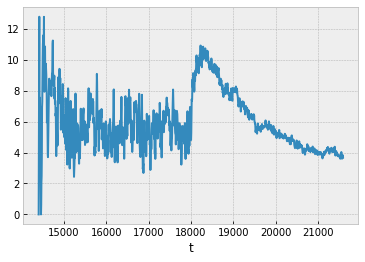

In [108]:
data2.groupby('t').mean()['speed'].plot()
# is this km/h?